In [1]:
import tyxe

In [2]:
import numpy as np
import pandas as pd
import torch
import pyro
from torch import nn
from torch.utils.data import Dataset, DataLoader
import functools
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.infer import SVI
import os

In [3]:
# set matplotlib settings
%matplotlib inline
plt.style.use('ggplot')

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Device: {}'.format(device))
#if torch.cuda.is_available():
#        torch.set_default_tensor_type('torch.cuda.FloatTensor')
#else:
#        torch.set_default_tensor_type('torch.FloatTensor')

Device: cuda:0


In [5]:
data = pd.read_csv("data/sign_mnist_train.csv")
#profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
#profile.to_widgets()
tdata = pd.read_csv("data/sign_mnist_test.csv")

In [6]:
dataset_size = len(data["label"])

24


<AxesSubplot:ylabel='Frequency'>

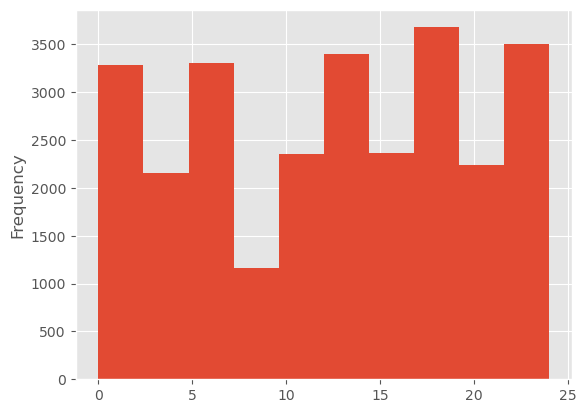

In [7]:
n_classes = data["label"].nunique()
print(n_classes)
data["label"].plot.hist()

In [8]:
y_train = data["label"]
X_train = data.drop(columns =["label"])

In [9]:
y_test = tdata["label"]
X_test = tdata.drop(columns =["label"])

In [10]:
# # DATA PARSER AND LOADER FOR THE VALUES OF SKIN
# class HandSignsDataset(Dataset):
#     def __init__(self, images, labels=None, transforms=None):
#         self.X = np.asarray(images).astype(np.float32)
#         self.y = labels
#         self.transforms = transforms
#         #print("GUARDA QUI", self.y.shape)
         
#     def __len__(self):
#         return (len(self.X))
    
#     def __getitem__(self, i):
#         data = self.X[i, :]
#         data = data.reshape(28, 28, 1)
       
#         my_y = self.y.values[i]
        
#         if self.transforms:
#             data = self.transforms(data)
            
#         if self.y is not None:
#             return (data, my_y)
#         else:
#             return data
        
class SignLanguageDataset(Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        
        label = self.df.iloc[index, 0]
        
        img = self.df.iloc[index, 1:].values.reshape(28, 28)
        img = torch.Tensor(img).unsqueeze(0)
        if self.transform is not None:
            img =self.transform(img)
        
        return img, label

In [11]:
y_train[y_train > 8] = y_train[y_train > 8] - 1
pf = y_train[y_train == 9]

In [12]:
y_test[y_test > 8] = y_test[y_test > 8] - 1

In [13]:
train_transforms = transforms.Compose([ transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.Normalize(110, 110)]) #  transforms.ToTensor(),
                                 #transforms.Normalize(159, 40)])

test_transforms = transforms.Compose([transforms.Normalize(110, 110)])   

train_data = SignLanguageDataset(data, transform=train_transforms)

test_data = SignLanguageDataset(tdata, transform=test_transforms)


In [14]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=100, pin_memory=use_cuda, num_workers=2 * int(use_cuda), shuffle=True) #, generator=generator)    
testloader = DataLoader(test_data, batch_size=100, shuffle=True) #, generator=generator)

In [15]:
data_iter = iter(trainloader)
images, labels = next(data_iter)#data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels  tensor([ 6, 19,  7, 23,  5, 20,  6,  5, 19, 12, 17,  1,  4, 22, 19,  0,  1,  6,
        10, 15, 19, 17,  2,  1, 14,  1, 23, 18, 20, 14, 12, 18,  9, 12, 12,  0,
        16, 11,  9, 17, 23,  7,  3,  9, 14,  4, 10, 13,  8, 12, 20, 14, 16, 11,
        16,  1,  5, 11, 10,  3,  8,  5,  5, 13,  5, 16,  9, 12,  3,  6, 17, 17,
        18, 13,  7,  5, 13, 16,  8, 18,  9, 22, 18,  9, 23,  8,  8,  4,  4, 20,
        16,  3, 17, 10,  4,  3, 16, 22, 23, 12])


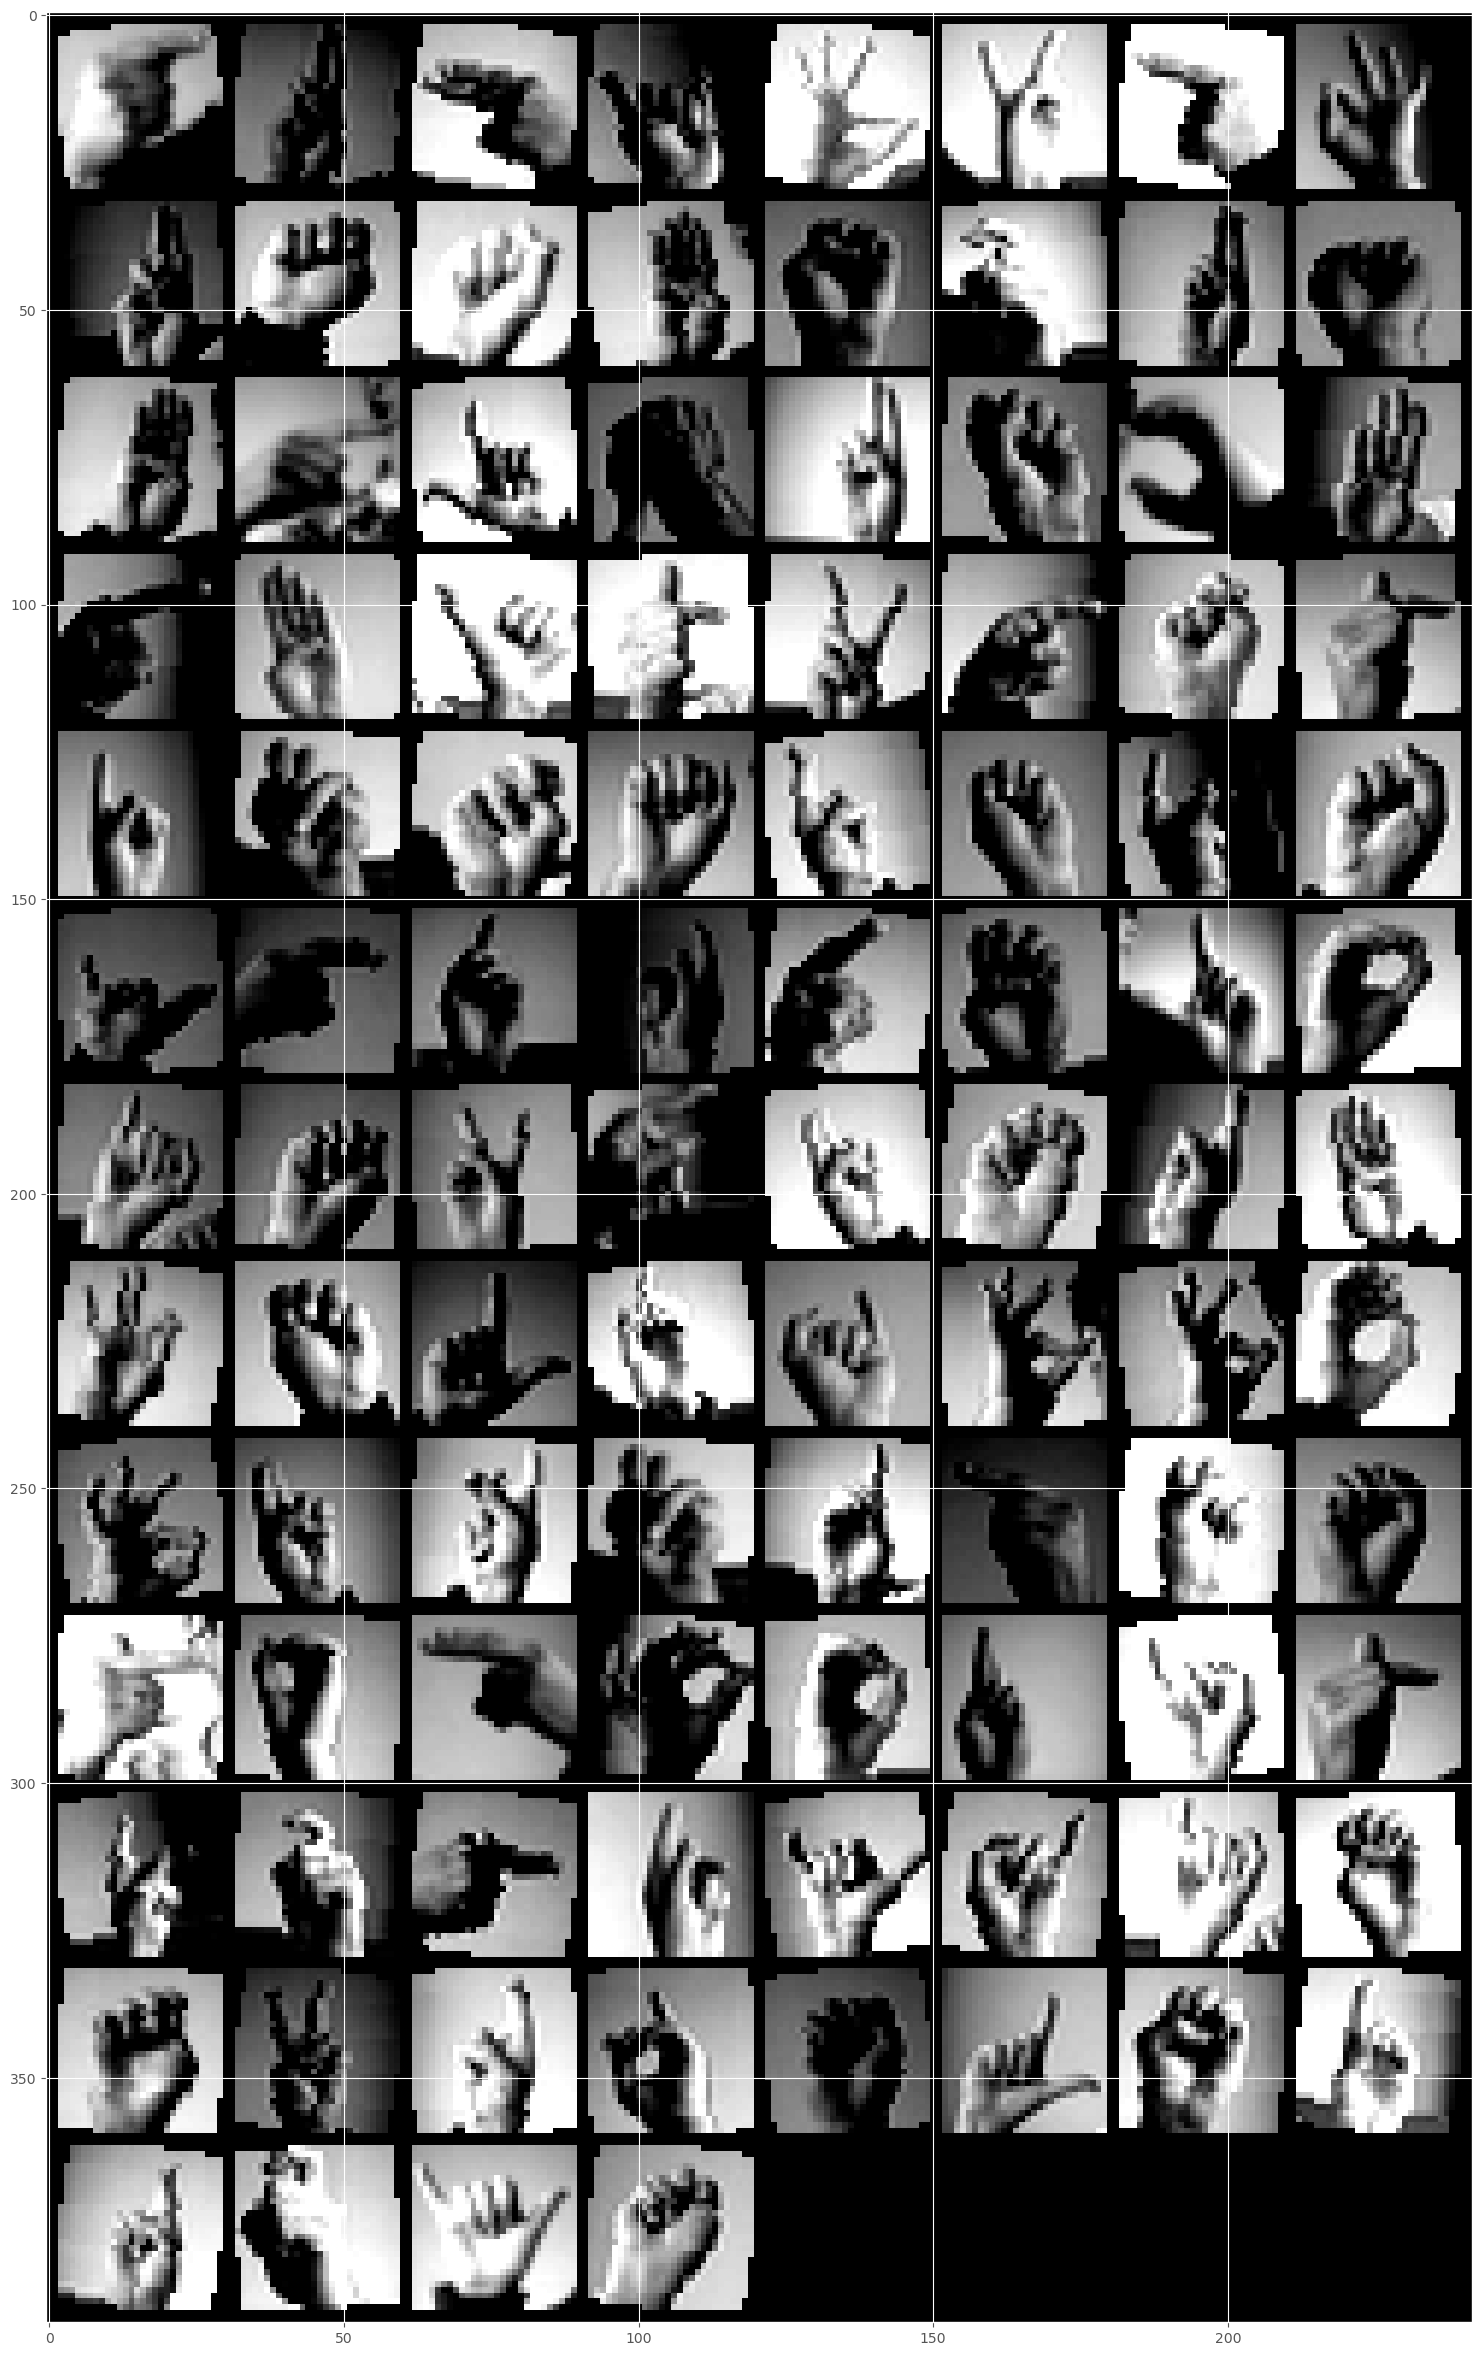

In [16]:
grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(60,30))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels ", labels)

In [17]:
input_shape = (1,60,60)
output_size = n_classes

In [18]:
activ = nn.LeakyReLU 
in_channels = input_shape[0]

net = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                              out_channels=64,
                              kernel_size=5,
                              ),
                    activ(),
                    nn.MaxPool2d(2,2),
                    #nn.BatchNorm2d(64),
                    nn.Conv2d(in_channels=64,
                              out_channels=512,
                              kernel_size=3,
                              ),
                    activ(),
                    nn.MaxPool2d(2,2),
                    #nn.Dropout(p=0.3),
                    #nn.Conv2d(in_channels=512,
                    #          out_channels=1024,
                    #          kernel_size=3,
                    #          ),
                    #activ(),
                    #nn.MaxPool2d(2,2),
                    #nn.BatchNorm2d(1024),
                    #nn.Dropout(p=0.4),
                    #nn.Conv2d(in_channels=1024,
                    #          out_channels=1024,
                    #          kernel_size=2,
                    #          ),
                    #activ(),
                    #nn.MaxPool2d(2,2),
                    #nn.Dropout(p=0.4),
                    nn.Flatten(),
                    nn.Linear(512*5*5, 256),
                    #nn.Dropout(p=0.5),
                    activ(),
                    nn.Linear(256, output_size)).to(device)

#net = net.to(device)

In [19]:
prior_kwargs = dict()#expose_all=False, hide_module_types=(nn.BatchNorm2d,))

likelihood = tyxe.likelihoods.Categorical(len(trainloader.sampler))

prior = tyxe.priors.IIDPrior(dist.Normal(torch.zeros(1, device=device), torch.ones(1, device=device)), **prior_kwargs)
                                 
guide = functools.partial(tyxe.guides.AutoNormal,
                                  init_loc_fn=tyxe.guides.PretrainedInitializer.from_net(net, prefix="net"), init_scale=1e-4,
                                  max_guide_scale=1)#, train_loc=not scale_only)
bnn = tyxe.VariationalBNN(net, prior, likelihood, guide)

In [20]:
pyro.clear_param_store()

lr = 1e-3
n_epochs = 100
optim = pyro.optim.Adam({"lr": lr})

error = []

def callback(b, i, avg_elbo):
    avg_err, avg_ll = 0., 0.
    b.eval()
    for x, y in iter(testloader):
        err, ll = b.evaluate(x.to(device), y.to(device), num_predictions=10)
        avg_err += err / len(testloader.sampler)
        avg_ll += ll / len(testloader.sampler)
    error.append(avg_err)
    print(end = f"  ELBO={avg_elbo}; test error={100 * avg_err:.2f}%; LL={avg_ll:.4f}")
    b.train()

In [21]:
#with tyxe.poutine.local_reparameterization():
bnn.fit(trainloader, optim, n_epochs, callback, device=device)

  ELBO=30715550.865454547; test error=9.04%; LL=-0.3015  ELBO=29712410.82181818; test error=7.32%; LL=-0.2597  ELBO=28727155.19272727; test error=8.31%; LL=-0.2821  ELBO=27742667.025454547; test error=4.80%; LL=-0.2013  ELBO=26758383.418181818; test error=5.17%; LL=-0.2128  ELBO=25774597.381818183; test error=3.86%; LL=-0.2018  ELBO=24790648.87272727; test error=6.32%; LL=-0.2669  ELBO=23807066.152727272; test error=3.85%; LL=-0.1806  ELBO=22823601.243636362; test error=3.85%; LL=-0.1874  ELBO=21840563.73818182; test error=4.06%; LL=-0.1870  ELBO=20858497.323636364; test error=5.56%; LL=-0.2431  ELBO=19877413.076363638; test error=3.67%; LL=-0.1556  ELBO=18896434.174545456; test error=4.28%; LL=-0.2019  ELBO=17917274.472727273; test error=5.44%; LL=-0.2206  ELBO=16939814.05090909; test error=6.90%; LL=-0.2340  ELBO=15964686.814545454; test error=5.72%; LL=-0.2424  ELBO=14992550.581818182; test error=3.78%; LL=-0.2256  ELBO=14023963.661818182; test error=4.41%; LL=-0.1803  ELBO=13060317

In [22]:
error_cpu = [error[i].to("cpu")*100 for i in range(len(error))]

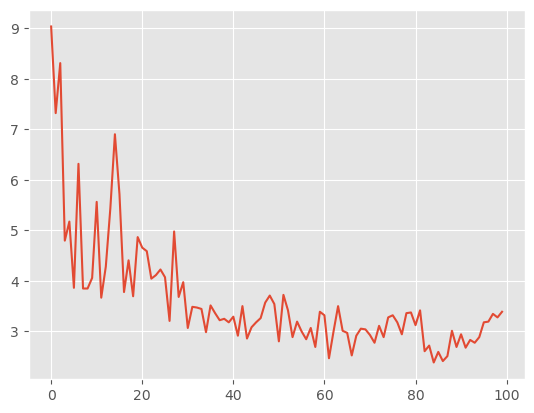

In [23]:
_=plt.plot(error_cpu)

In [24]:
# pyro.get_param_store().save(os.path.join(output_dir, "param_store.pt"))
# torch.save(bnn.state_dict(), os.path.join(output_dir, "state_dict.pt"))

In [23]:
test_predictions = torch.cat([bnn.predict(x.to(device), num_predictions=1) for x, _ in iter(testloader)])

In [24]:
print(test_predictions[60])

tensor([-1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01,
        -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01,
        -1.5942e+01, -1.1921e-07, -1.5942e+01, -1.5942e+01, -1.5942e+01,
        -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01,
        -1.5942e+01, -1.5942e+01, -1.5942e+01, -1.5942e+01], device='cuda:0')


Text(0.5, 1.0, 'Prediction likelihood')

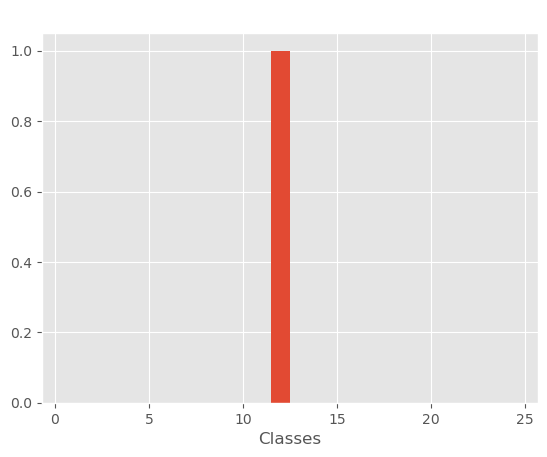

In [25]:
t = np.array([test_predictions[60][i].to("cpu") for i in range(len(test_predictions[0]))])
#hist = torch.histc(t, bins = 2, min = 0, max = 1)

bins = 24
x = range(1,25,1)

#plt.bar(x, hist, align='center')
plt.bar(x, np.exp(t), width=1, align='center')

plt.xlabel('Classes')
plt.title('Prediction likelihood')

In [28]:
# SAVE AND LOAD A PRE-TRAINED BNN

In [29]:
## SAVE

output_dir = '/home/thomas/Documents/repositories/sign-language-detection/output'

if output_dir is not None:
     pyro.get_param_store().save(os.path.join(output_dir, "param_store.pt"))
     torch.save(bnn.net.state_dict(), os.path.join(output_dir, "state_dict.pt"))